 # Topic Extraction
 The following pipeline will be used to extract topics from the reviews:
 - import the data (pandas)
 - clean the data
   - correct spelling (autocorrect)
   - remove punctuation (re.sub(r"[^\w\s]", "", text))
   - remove stop words
   - remove numbers (re.sub(r'\d+', '', text))
   - lemmatize (nltk.stem.WordNetLemmatizer)
 - audition topic extraction methods
   - spacy with bertopic
   - gensim LDAModel
   - sklearn LDA, NMF, LSA, etc.
 - visualize topics per topic extraction method
 - consider grouping topics per star rating
 - discuss results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from autocorrect import Speller
import spacy
from bertopic import BERTopic
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import random
from wordcloud import WordCloud

# set the plot style
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

In [2]:
# read in the stop words
# stop words taken from https://gist.github.com/deekayen/4148741
with open("data/stop_words.txt", "r") as f:
    stop_words = [x.replace("\n", "") for x in f.readlines()[1:]] + ["i", "ive", " "]

In [3]:
# create a function which will return a flattened list given a list of lists
def flatten(l):
    """This function takes a list of lists and returns a flattened list."""
    return [item for sublist in l for item in sublist]


# "adjectives_text" column
def get_adjectives(text):
    """This function takes a string of text and returns a list of adjectives."""
    blob = TextBlob(text)
    return [word for (word, tag) in blob.tags if tag == "JJ"]


# "prepped_text" column
def prepare_text(text):
    """This function takes a string of text and returns a cleaned version of the text.

    Parameters
    ==========
    text: str
        A string of text to be cleaned

    Returns
    =======
    str

    Example
    =======
    >>> example_str = "This is a string of text. It has punctuation, numbers, and stop words - 1000."
    >>> cleaned_str = prepare_text(example_str)

    """

    auto_spell = Speller(lang="en")
    # correct spelling
    autocorrected_text = auto_spell(text)
    # remove punctuation
    removed_punc_text = re.sub(r"[^\w\s]", "", autocorrected_text)
    # remove stop words
    word_tokens = word_tokenize(removed_punc_text)
    no_stop_words_text = " ".join(
        [w for w in word_tokens if not w.lower() in stop_words]
    )
    # remove numbers
    no_numbers_text = re.sub(r"\d+", "", no_stop_words_text)
    # lemmatize
    lemmatized_text = " ".join(
        [WordNetLemmatizer().lemmatize(x) for x in no_numbers_text.split(" ")]
    )
    # return the cleaned text (in lowercase)
    return lemmatized_text.lower()

 ### Importing the data and applying the preprocessing steps

In [4]:
df = (
    pd.read_json(path_or_buf="data/train_reviews.json").assign(
        **{
            # reassigning the stars column to be an integer
            "stars": lambda x: x["stars"].str.extract("(\d+)").astype(int),
            # prepare_text function to each row (this step takes about 4 mins)
            "prepped_text": lambda x: x["text"].apply(lambda x: prepare_text(x)),
            # creating a "adjectives_text" column pulling out all the
            # adjectives from the "prepped_text" column to quickly see what adjectives
            # are used to get an idea of tone
            "adjectives_text": lambda d: d.apply(
                lambda x: ", ".join(get_adjectives(x["prepped_text"])), axis=1
            ),
        }
    )
    # when looking at the data initially, I noticed that there are some reviews
    # that are complete duplicates across the title and text columns. I decided to drop these
    # to avoid any over representation of these reviews
    .drop_duplicates(subset=["title", "text"])
    # following the row dropping reset the index to be sequential
    .reset_index(drop=True)
)
df.head()

,date,title,text,url,stars,prepped_text,adjectives_text
0,2015-10-10 14:32:51+00:00,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,https://uk.trustpilot.com/review/www.nationalr...,1,used national twice occasion staff unpleasant ...,"national, twice, unpleasant, unfriendly, incom..."
1,2015-09-22 17:04:56+00:00,Pretty awful service,I phoned National rail to find out why several...,https://uk.trustpilot.com/review/www.nationalr...,1,phone national train cancelled brighton none a...,"national, english, southampton, central, centr..."
2,2015-03-13 23:37:05+00:00,Awful staff,I travel from Brokenhast to southampton centra...,https://uk.trustpilot.com/review/www.nationalr...,1,brokenhast southampton central without ticket ...,"southampton, central, awful, sarcastic, crimin..."
3,2015-01-13 12:26:52+00:00,Very good,Saved about £50 on a single trip using Nationa...,https://uk.trustpilot.com/review/www.nationalr...,4,saved using nationalrail specific train inexp...,"specific, easy"
4,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site wh...,https://uk.trustpilot.com/review/www.nationalr...,4,national enquiry site planning journey site al...,national


 ### Initial light Exploratory Data Analysis (EDA)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   date             1439 non-null   datetime64[ns, UTC]
 1   title            1439 non-null   object             
 2   text             1439 non-null   object             
 3   url              1439 non-null   object             
 4   stars            1439 non-null   int64              
 5   prepped_text     1439 non-null   object             
 6   adjectives_text  1439 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(1), object(5)
memory usage: 78.8+ KB


 It appears that there are a lot of one star reviews. This is likely
 to influence the topic extraction output. Consider running the topic
 extraction on the one star reviews and then the three - five star reviews.

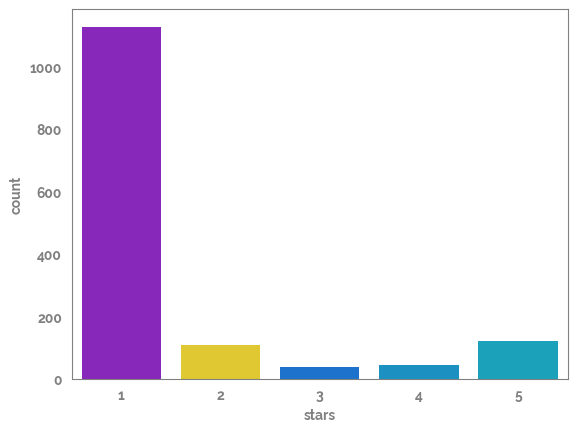

In [6]:
_ = sns.countplot(x="stars", data=df)

 It appears that the reviews are mostly from later years. This is likely
 to influence the topic extraction output. Consider grouping the reviews
 per year and then extracting topics.

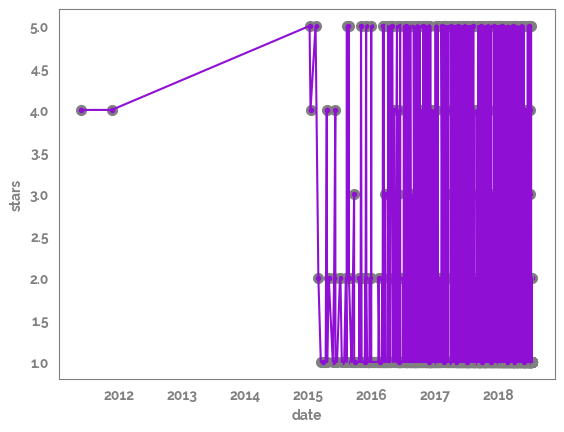

In [7]:
_ = sns.lineplot(data=df, x="date", y="stars")
_ = sns.scatterplot(
    data=df, x="date", y="stars", edgecolor="grey", linewidth=2, zorder=1
)

In [8]:
# show the date range of the reviews
df["date"].min(), df["date"].max()

(Timestamp('2011-05-28 15:00:36+0000', tz='UTC'),
 Timestamp('2018-07-17 13:59:52+0000', tz='UTC'))

 visualizing the top 20 adjectives used in the reviews to get an idea of the tone

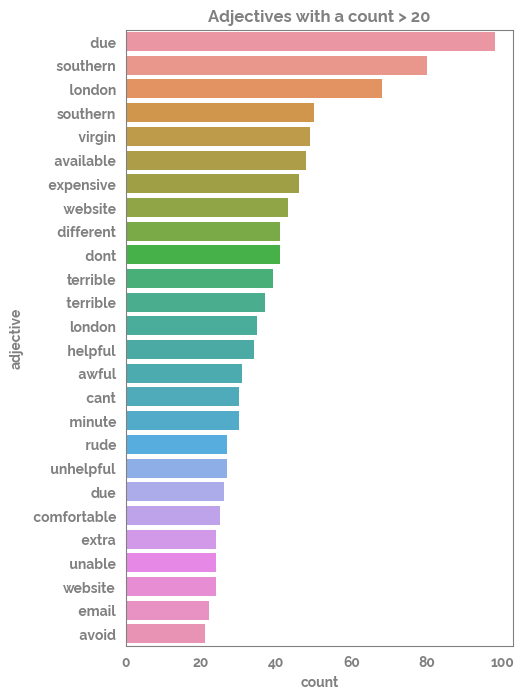

In [9]:
count_cutoff = 20
adjectives_df = (
    df["adjectives_text"]
    .str.split(",", expand=True)
    .stack()
    .reset_index()
    .drop(["level_0", "level_1"], axis=1)
    .rename(columns={0: "adjective"})
    .value_counts()
    .reset_index()
    .rename(columns={"index": "adjective", 0: "count"})
    .loc[lambda d: d["count"] > count_cutoff]
    .loc[lambda d: ~d["adjective"].isin(["", " ’"])]
)
_ = plt.figure(figsize=(5, 8))
_ = sns.barplot(data=adjectives_df, y="adjective", x="count")
_ = plt.title(f"Adjectives with a count > {count_cutoff}")

 It appears that there are duplicate review titles. These are often
 one word titles like "Awful" or "Terrible". Another indication of tone.

In [10]:
title_counts = df["title"].value_counts()
top_titles = title_counts[title_counts > 2].index.tolist()
# select and visualize the reviews that have a title that is duplicated
df[df["title"].isin(top_titles)].sort_values("title")

,date,title,text,url,stars,prepped_text,adjectives_text
81,2018-04-26 13:47:12+00:00,Awful,I booked a train for 10am online the day befor...,https://uk.trustpilot.com/review/www.eastmidla...,1,booked am online commute cheaper technical boo...,"online, technical, filmed, technical, differen..."
1187,2018-03-30 00:18:41+00:00,Awful,I unforantly have to use GWR 5 days a week to ...,https://uk.trustpilot.com/review/www.gwr.com?p...,1,unforantly wr day london,wr
294,2017-05-14 09:04:03+00:00,Awful,Awful! Me (17) and my dad (55) have been fined...,https://uk.trustpilot.com/review/www.virgintra...,1,awful fined getting offbeat time apparently...,"offbeat, awful, polite, lesson, minute, peak"
506,2015-04-05 21:55:57+00:00,Awful,I am shocked at Virgin Trains the whole experi...,https://uk.trustpilot.com/review/www.virgintra...,1,shocked virgin trains awful,awful
549,2016-08-02 12:58:40+00:00,Awful,These virgin trains are jokes you reserve seat...,https://uk.trustpilot.com/review/www.virgintra...,1,virgin train joke reserve seat adult dont si...,reserve
615,2018-02-06 07:23:56+00:00,Awful,"Consistently late, poor connections and no apo...",https://uk.trustpilot.com/review/www.virgintra...,1,consistently connection apology travelling new...,"newcastle, expensive"
1078,2016-08-25 15:35:06+00:00,Awful,Worst train company ever.,https://uk.trustpilot.com/review/www.southernr...,1,worst,
856,2016-11-10 11:53:29+00:00,Awful customer service,Took over one month to receive response to com...,https://uk.trustpilot.com/review/www.eurostar....,1,response complaint staff member aggressive rud...,"aggressive, redeem"
743,2018-03-19 08:55:02+00:00,Awful customer service,Awful customer service. Train cancelled so I’v...,https://uk.trustpilot.com/review/www.buyticket...,1,awful customer service cancelled emailed refun...,awful
465,2016-01-31 08:15:17+00:00,Awful customer service,I booked a return ticket to Glasgow from derby...,https://uk.trustpilot.com/review/www.virgintra...,1,booked return ticket glasgow derby crew everyt...,derby


 ## Define the different pipelines

 ### Topic Extraction with Spacy and BERTopic

In [11]:
def spacy_bertopic_pipeline(list_of_texts):
    """This function takes a list of texts and returns a dataframe of topics
    and their associated words with corresponding weights, based on the spacy
    and bertopic topic extraction methods.

    Parameters
    ==========
    list_of_texts: list
        A list of texts to be used to extract topics

    Returns
    =======
    pd.DataFrame

    Example
    =======
    >>> import pandas as pd
    >>> import seaborn as sns
    >>> import random
    >>> import spacy
    >>> from bertopic import BERTopic
    >>> df = pd.read_json(path_or_buf="data/train_reviews.json")
    >>> df["adjectives_text"] = df.apply(lambda x: ", ".join(get_adjectives(x["prepped_text"])), axis=1)
    >>> topics_df = spacy_bertopic_pipeline(df["adjectives_text"].tolist(), plot=True)

    """
    # load the spacy model
    # python -m spacy download en_core_web_md
    nlp = spacy.load("en_core_web_md")
    # define the bertopic model with the spacy model as the embedding model
    topic_model = BERTopic(
        embedding_model=nlp,
        language="english",
        calculate_probabilities=True,
        top_n_words=10,
        nr_topics=10,
    )
    # fit the model to the list of texts
    _, _ = topic_model.fit_transform(list_of_texts)
    # get the topics and their associated words and weights
    return (
        pd.DataFrame(
            [topic_model.get_topic(topic) for topic in topic_model.get_topics().keys()]
        )
        .T.melt(var_name="topic_id")
        .assign(
            **{
                "topic_id": lambda x: x["topic_id"].astype(str),
                "word": lambda x: x["value"].str[0],
                "weight": lambda x: x["value"].str[1].astype(float),
            }
        )
        .replace("", np.nan)
        .dropna()
        .drop(columns=["value"])
    )

 ### Topic Extraction with LDA (gensim)

In [12]:
def lda_pipeline(list_of_texts):
    """This function takes a list of texts and returns a dataframe of topics
    and their associated words with corresponding weights, based on the LDA
    topic extraction method.

    Parameters
    ==========
    list_of_texts: list
        A list of texts to be used to extract topics
    plot: bool
        A boolean indicating whether or not to plot the topics

    Returns
    =======
    pd.DataFrame

    Example
    =======
    >>> import pandas as pd
    >>> import seaborn as sns
    >>> import random
    >>> import spacy
    >>> from bertopic import BERTopic
    >>> df = pd.read_json(path_or_buf="data/train_reviews.json")
    >>> df["adjectives_text"] = df.apply(lambda x: ", ".join(get_adjectives(x["prepped_text"])), axis=1)
    >>> topics_df = lda_pipeline(df["adjectives_text"].tolist(), plot=True)

    """

    # create a dictionary of words and their respective integer ids
    dictionary = Dictionary(list_of_texts)
    # create a corpus object which contains the integer ids of the words
    # along with the number of times they appear in each document
    corpus = [dictionary.doc2bow(text) for text in list_of_texts]
    # create the LDA model
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=10,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha="auto",
        per_word_topics=True,
    )

    return (
        pd.DataFrame(
            lda_model.print_topics(), columns=["topic_id", "topic_words_weights"]
        )["topic_words_weights"]
        .str.split("+", expand=True)
        .T.melt(var_name="topic_id")
        .assign(
            **{
                "topic_id": lambda x: x["topic_id"].astype(str),
                "weight": lambda x: x["value"]
                .str.split("*", expand=True)[0]
                .astype(float),
                "word": lambda x: x["value"]
                .str.split("*", expand=True)[1]
                .str.replace('"', ""),
            }
        )
        .drop(columns=["value"])
    )

 ### Topic Extraction with LDA, NMF, and LSA (sklearn)

In [13]:
def sklearn_pipeline(
    list_of_texts,
    approach="LDA",
    n_components=10,
    n_top_words=10,
    beta_loss="frobenius",
):
    """This function takes a list of texts and returns a dataframe of topics
    and their associated words with corresponding weights, based on the LDA,
    NMF, or LSA topic extraction method.

    Parameters
    ==========
    list_of_texts: list
        A list of texts to be used to extract topics
    approach: str
        A string indicating which topic extraction method to use. Options are
        LDA, NMF, or LSA.
    n_components: int
        An integer indicating the number of topics to extract
    n_top_words: int
        An integer indicating the number of words to extract per topic
    beta_loss: str
        A string indicating the beta loss function to use. Options are
        frobenius or kullback-leibler. Only used for NMF.
    plot: bool
        A boolean indicating whether or not to plot the topics

    Returns
    =======
    pd.DataFrame

    Example
    =======
    >>> df = pd.read_json(path_or_buf="data/train_reviews.json")
    >>> df["adjectives_text"] = df.apply(lambda x: ", ".join(get_adjectives(x["prepped_text"])), axis=1)
    >>> topics_df = sklearn_pipeline(df["adjectives_text"].tolist(), approach="LDA")
    >>> topics_df = sklearn_pipeline(df["adjectives_text"].tolist(), approach="NMF")
    >>> topics_df = sklearn_pipeline(df["adjectives_text"].tolist(), approach="NMF", beta_loss="kullback-leibler)
    >>> topics_df = sklearn_pipeline(df["adjectives_text"].tolist(), approach="LSA")

    """
    if approach == "LDA":
        tf_vectorizer = CountVectorizer()
        tf = tf_vectorizer.fit_transform(list_of_texts)
        lda = LatentDirichletAllocation(
            n_components=n_components,
            max_iter=5,
            learning_method="online",
            learning_offset=50.0,
            random_state=0,
        )
        _ = lda.fit(tf)

        feature_names = tf_vectorizer.get_feature_names_out()

        df_list = []
        for topic_idx, topic in enumerate(lda.components_):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
            to_append_df = pd.DataFrame(
                {"topic_id": topic_idx, "word": top_features, "weight": weights}
            )
            df_list.append(to_append_df)

        return pd.concat(df_list).assign(
            **{
                "topic_id": lambda x: x["topic_id"].astype(str),
            }
        )
    elif approach == "NMF":
        tfidf_vectorizer = TfidfVectorizer()
        tfidf = tfidf_vectorizer.fit_transform(list_of_texts)
        if beta_loss == "frobenius":
            nmf = NMF(
                n_components=n_components,
                random_state=0,
                beta_loss=beta_loss,
                alpha_W=0.00005,
                alpha_H=0.00005,
                l1_ratio=1,
                init="nndsvd",
            )
            _ = nmf.fit(tfidf)
        elif beta_loss == "kullback-leibler":
            nmf = NMF(
                n_components=n_components,
                random_state=0,
                init="nndsvd",
                beta_loss="kullback-leibler",
                solver="mu",
                max_iter=1000,
                alpha_W=0.00005,
                alpha_H=0.00005,
                l1_ratio=0.5,
            )
        else:
            raise ValueError(
                "beta_loss must be either 'frobenius' or 'kullback-leibler'"
            )

        _ = nmf.fit(tfidf)

        feature_names = tfidf_vectorizer.get_feature_names_out()

        df_list = []
        for topic_idx, topic in enumerate(nmf.components_):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
            df_list.append(
                pd.DataFrame(
                    {"topic_id": topic_idx, "word": top_features, "weight": weights}
                )
            )

        return pd.concat(df_list).assign(
            **{"topic_id": lambda x: x["topic_id"].astype(str)}
        )
    elif approach == "LSA":
        tfidf_vectorizer = TfidfVectorizer()
        tfidf = tfidf_vectorizer.fit_transform(list_of_texts)
        svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
        _ = svd.fit(tfidf)

        feature_names = tfidf_vectorizer.get_feature_names_out()

        df_list = []
        for topic_idx, topic in enumerate(svd.components_):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]
            df_list.append(
                pd.DataFrame(
                    {"topic_id": topic_idx, "word": top_features, "weight": weights}
                )
            )

        return pd.concat(df_list).assign(
            **{"topic_id": lambda x: x["topic_id"].astype(str)}
        )
    else:
        raise ValueError("approach must be either 'LDA', 'NMF', or 'LSA'")

 ### Run all the different topic extraction pipelines
 - consider using `adjectives_text` instead of `prepped_text` for the `column_name` variable
 for a cleaner set of topics

In [14]:
# column_name = "adjectives_text"
column_name = "prepped_text"

# BERTopic
bertopic_topics_df = spacy_bertopic_pipeline(list_of_texts=df[column_name].tolist())

# Gensim
if column_name == "adjectives_text":
    text_list = df[column_name].apply(lambda x: x.split(", ")).tolist()
else:
    text_list = df[column_name].apply(lambda x: x.split(" ")).tolist()

lda_gensim_topics_df = lda_pipeline(list_of_texts=text_list)

# Sklearn
lda_topics_df = sklearn_pipeline(
    list_of_texts=df[column_name].tolist(), approach="LDA", n_components=10
)

nmf_frobenius_topics_df = sklearn_pipeline(
    list_of_texts=df[column_name].tolist(),
    approach="NMF",
    beta_loss="frobenius",
    n_components=10,
)

nmf_kl_topics_df = sklearn_pipeline(
    list_of_texts=df[column_name].tolist(),
    approach="NMF",
    beta_loss="kullback-leibler",
    n_components=10,
)

lsa_topics_df = sklearn_pipeline(
    list_of_texts=df[column_name].tolist(),
    approach="LSA",
    n_components=10,
)

In [15]:
# create a dictionary of the topic models
model_name_dict = {
    "BERT Topic": bertopic_topics_df,
    "Latent Dirichlet Allocation (Gensim)": lda_gensim_topics_df,
    "Latent Dirichlet Allocation (sklearn)": lda_topics_df,
    "Non-Negative Matrix Factorization (sklearn, Frobenius)": nmf_frobenius_topics_df,
    "Non-Negative Matrix Factorization (sklearn, KL)": nmf_kl_topics_df,
    "Latent Semantic Analysis (sklearn)": lsa_topics_df,
}

 ### Evaluate the topic models

In [16]:
# create a function to evaluate the topic models
# - visualize the top 10 words for each topic in each model as a barplot
# - visualize the top words in each model as a wordcloud
def evaluate_topic_model(
    data: pd.DataFrame,
    title: str = "Topic Model Evaluation",
):
    """A function to evaluate a topic model. It returns a facetgrid of plots the top 10 words for each topic.

    Parameters
    ==========
    data: pd.DataFrame
        A dataframe with the following columns: topic_id, word, weight
    title: str
        The suptitle of the plot

    Returns
    =======
    g: sns.FacetGrid

    Example
    =======
    >>> import pandas as pd
    >>> import seaborn as sns
    >>> import random
    >>> import spacy
    >>> from bertopic import BERTopic
    >>> df = pd.read_json(path_or_buf="data/train_reviews.json")
    >>> df["adjectives_text"] = df.apply(lambda x: ", ".join(get_adjectives(x["prepped_text"])), axis=1)
    >>> bertopic_topics_df = spacy_bertopic_pipeline(list_of_texts=df["adjectives_text"].tolist())
    >>> g, wordcloud_fig = evaluate_topic_model(
    ...     data=bertopic_topics_df,
    ...     title="BERTopic Topic Model Evaluation",
    ... )
    >>> g.fig.show()

    """
    r = lambda: random.randint(0, 255)
    g = sns.FacetGrid(
        data,
        col="topic_id",
        sharey=False,
        col_wrap=4,
        height=2,
        aspect=1.2,
    )
    _ = g.map(sns.barplot, "weight", "word", color="#%02X%02X%02X" % (r(), r(), r()))
    if len(g.axes) < 10:
        _ = g.fig.subplots_adjust(top=0.75)
    else:
        _ = g.fig.subplots_adjust(top=0.9)
    _ = g.fig.suptitle(title)

    wordcloud = WordCloud(
        background_color="#272322", max_font_size=40, max_words=30, colormap="Reds"
    ).generate(data["word"].str.cat(sep=" "))
    wordcloud_fig, _ = plt.subplots(figsize=(7, 7))
    _ = plt.imshow(wordcloud, interpolation="bilinear")
    _ = plt.axis("off")

    return g, wordcloud_fig

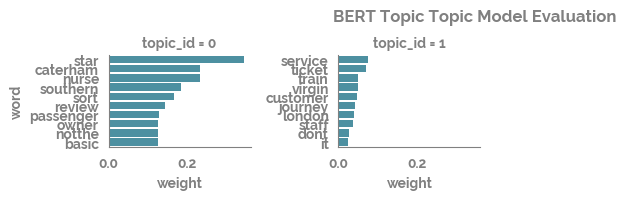

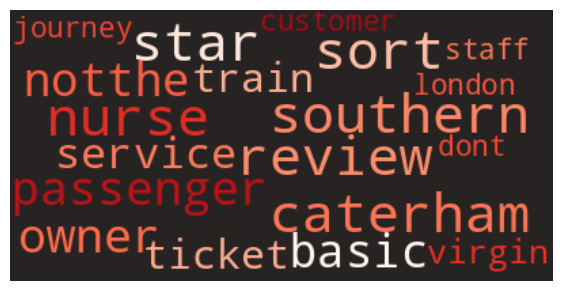

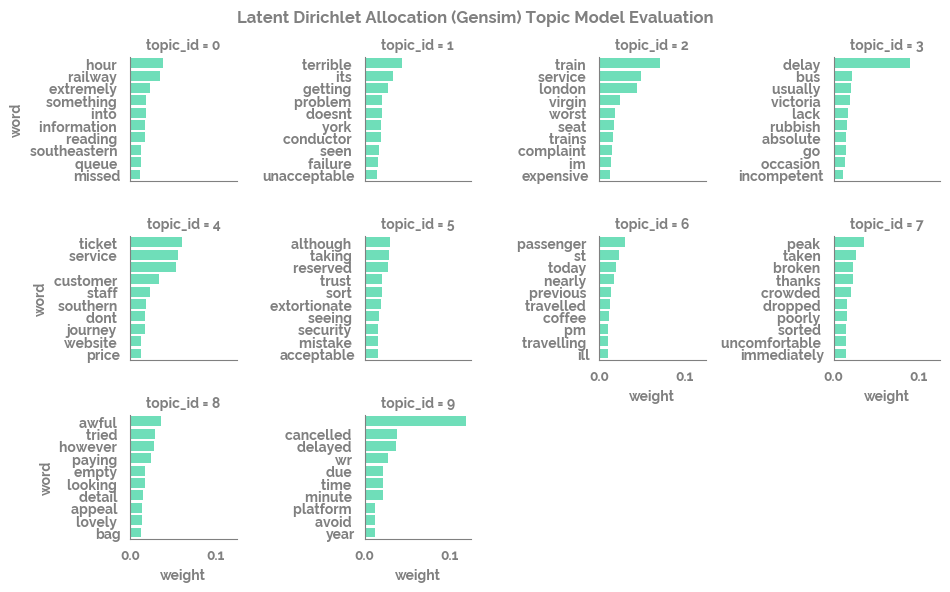

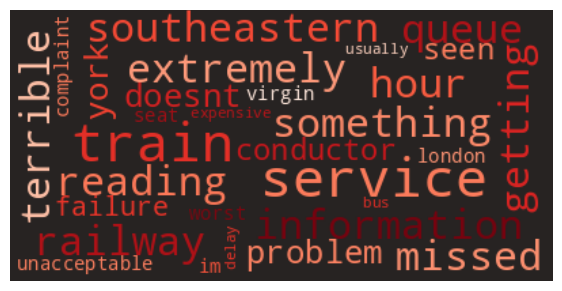

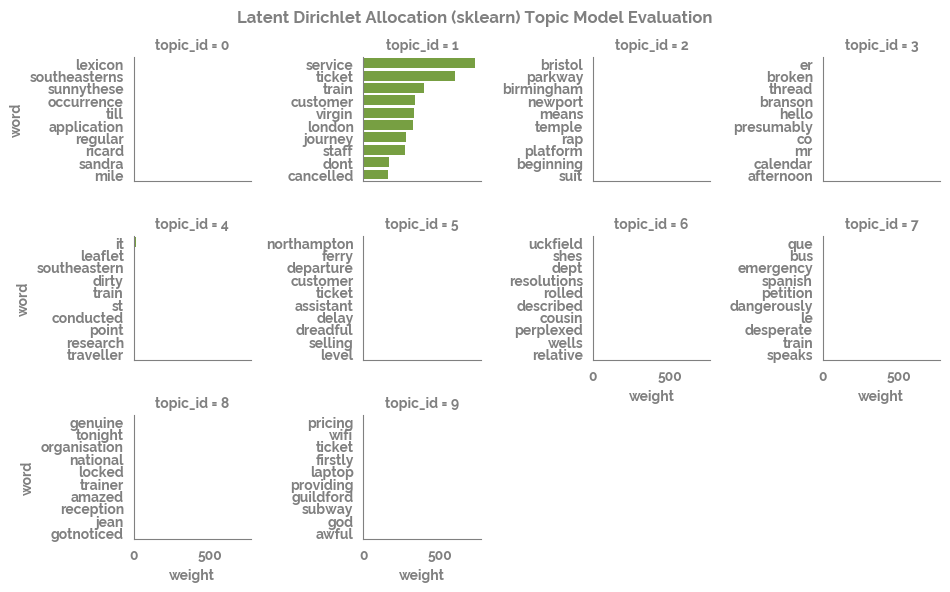

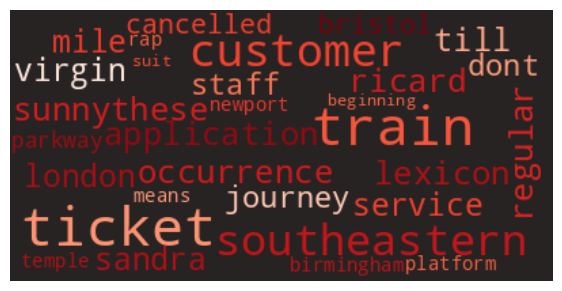

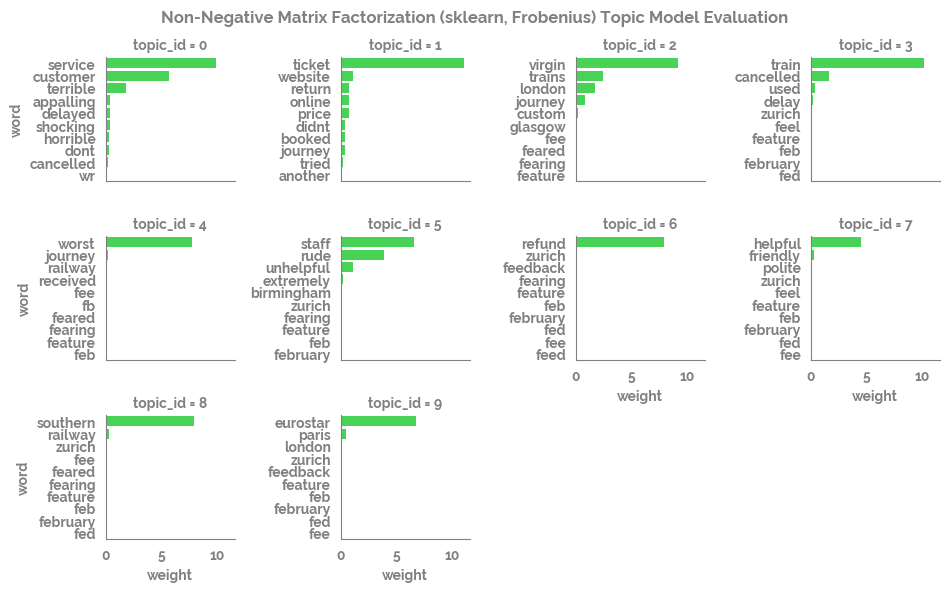

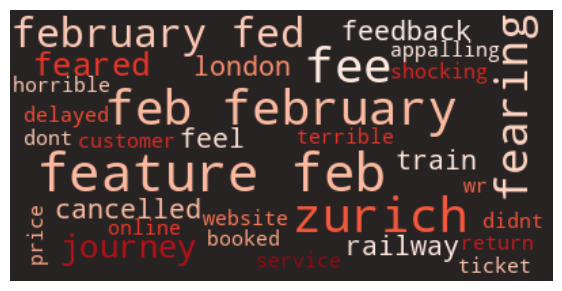

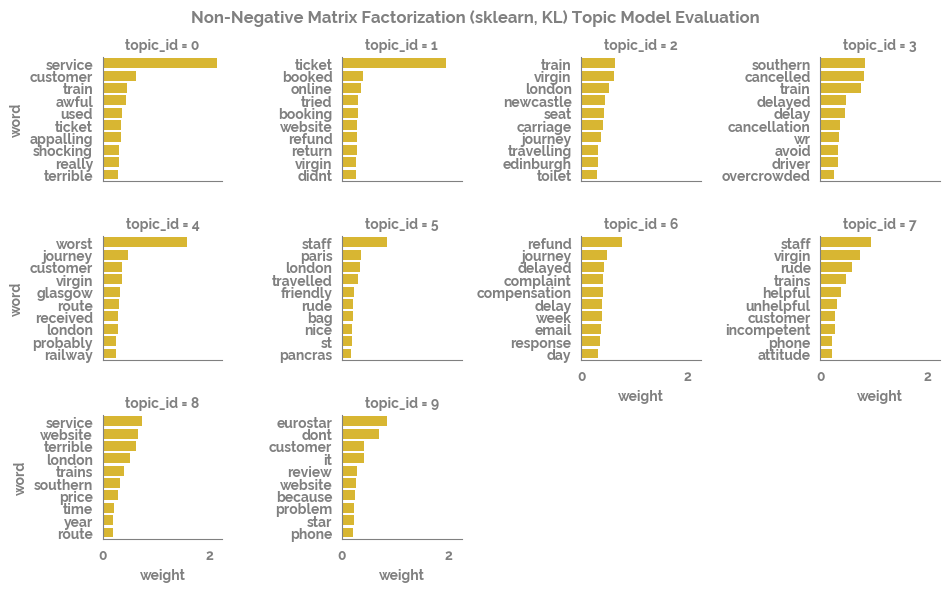

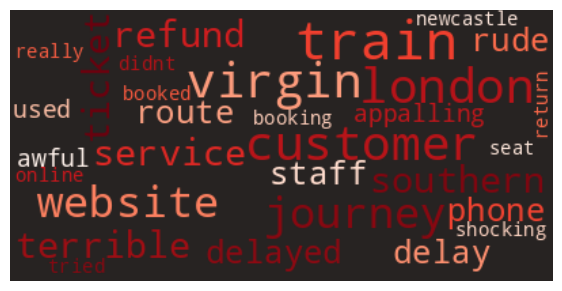

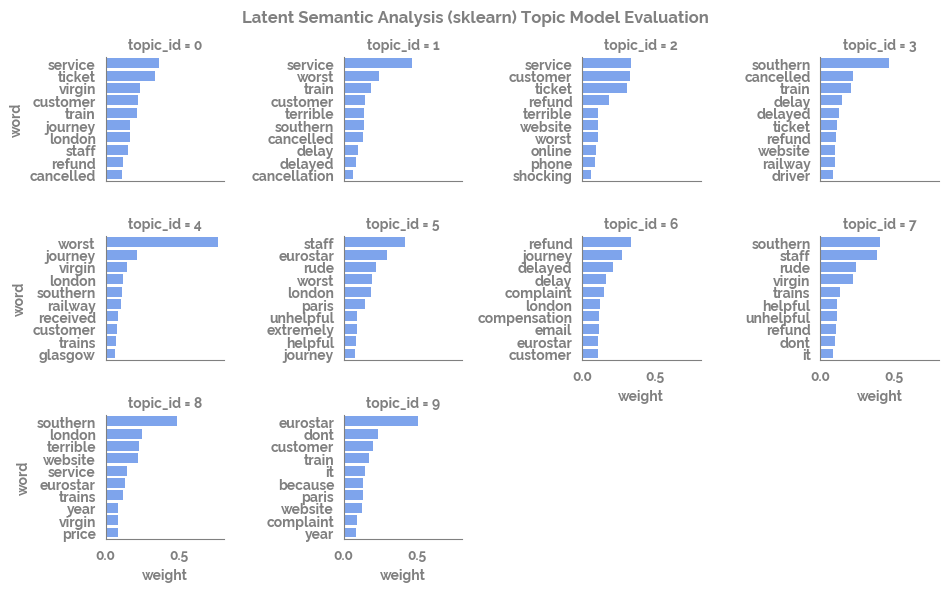

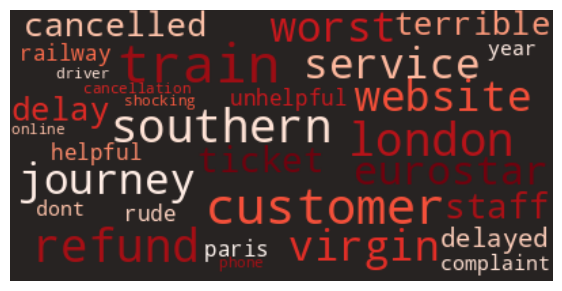

In [17]:
# run the function for each topic model and visualize the topics
for model_name in model_name_dict.keys():
    g, wordcloud_fig = evaluate_topic_model(
        data=model_name_dict[model_name],
        title=f"{model_name} Topic Model Evaluation",
    )
    g.fig.show()
    wordcloud_fig.show()

 As we saw earlier, there is a large amount of 1 star
 reviews in the dataset. Let's take the LDA gensim model and
 compare the output of the 1 star reviews to the output of the
 4 - 5 star reviews.

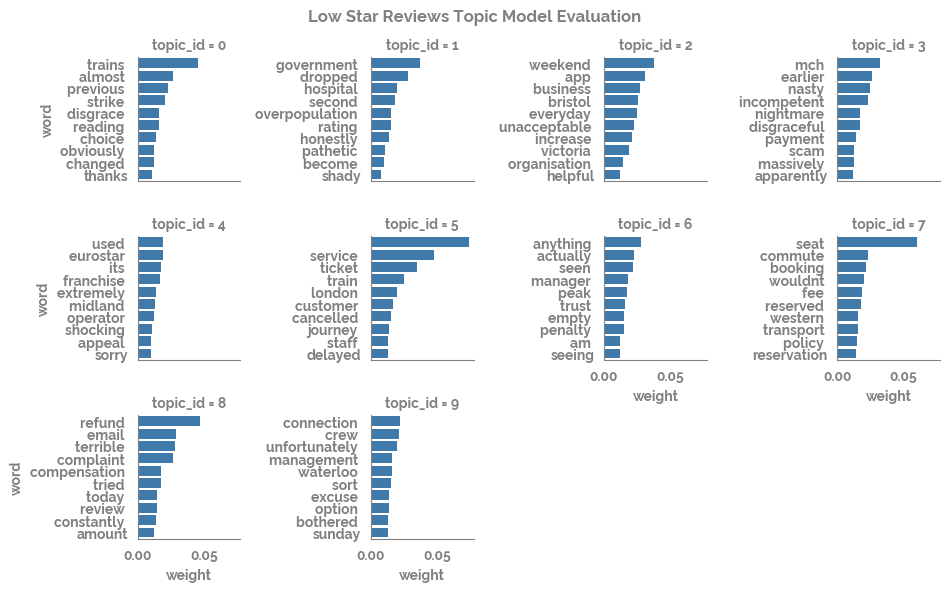

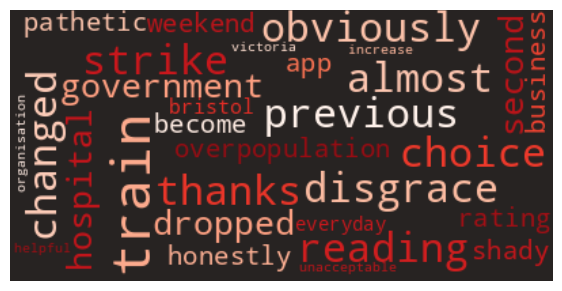

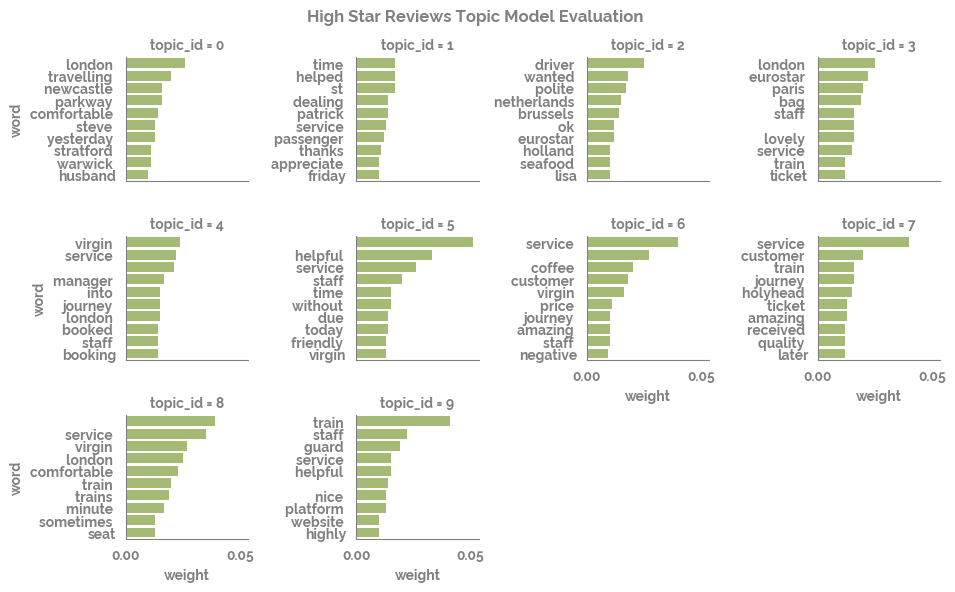

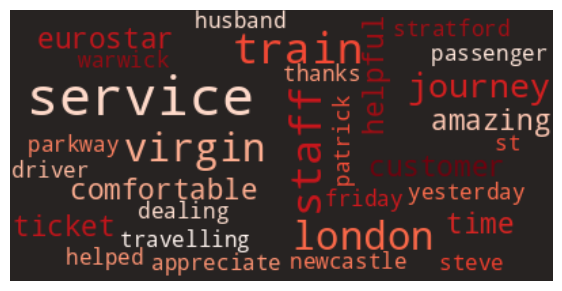

In [18]:
low_star_text = (
    df.loc[lambda d: d["stars"] == 1, "prepped_text"]
    .apply(lambda x: x.split(" "))
    .tolist()
)

high_star_text = (
    df.loc[lambda d: d["stars"] >= 4, "prepped_text"]
    .apply(lambda x: x.split(" "))
    .tolist()
)

low_star_lda_gensim_topics_df = lda_pipeline(list_of_texts=low_star_text)
high_star_lda_gensim_topics_df = lda_pipeline(list_of_texts=high_star_text)

g, wordcloud_fig = evaluate_topic_model(
    data=low_star_lda_gensim_topics_df,
    title=f"Low Star Reviews Topic Model Evaluation",
)
g.fig.show()
wordcloud_fig.show()
g, wordcloud_fig = evaluate_topic_model(
    data=high_star_lda_gensim_topics_df,
    title=f"High Star Reviews Topic Model Evaluation",
)
g.fig.show()
wordcloud_fig.show()

 ### Discussion
 No matter what topic model we use it seems that the main topics of interest are:
 - the customer service
 - the train service itself (delays, strikes, running on time etc.)
 - the state of the trains (cleanliness, etc.)
 - the ease of use of the website
 - in general the ease of booking a journey

 When looking at the low star reviews, we can see that the topics are more negative
 highlighting the poor customer service and the train service - choosing to focus
 more on delays and strikes. When the reviews are high stars, the main highlights
 are the customer service and the state of the trains.

 It is suggested for an improved perception of the company that they focus on
 the customer service being polite and helpful, and that the trains more reliably
 run on time.

 ### Thoughts on the assignment
 - I found the assignment to be very interesting and I enjoyed working on it.
 It was my first time really diving into topic modeling and I found it fascinating.
 - Given more time, I would have liked to:
   - have extracted the different train companies from the website strings and separated them when doing
 the topic modeling (similar to how the stars were separated)
   - have explored the other different available topic models more (e.g huggingface transformers)
   - do a more in depth review of the preprocessing steps (it can be seen that some spaces
 are still included in the output)
   - explored how text summarization in the preprocessing could be used to improve the topic models
 (i briefly tried it but it was very time consuming)
   - explored more interactive ways of visualizing the topic models